# The Depthwise Spherical Nonlinearity

In [1]:
import numpy as np
import tensorflow as tf

import sys
import time

import load_cifar

from keras import backend as K
from keras import models, layers, optimizers
from keras.engine.topology import Layer

%matplotlib inline
from IPython.core.pylabtools import figsize
from seaborn import plt

Using TensorFlow backend.


In [2]:
batches, batch_labels = load_cifar.Batches(include_labels=True)
train_images = np.concatenate(batches[:5])
train_labels = np.concatenate(batch_labels[:5])
test_images = batches[5]
test_labels = np.array(batch_labels[5])

In [3]:
train_labels_onehot = np.zeros((50000, 10))
train_labels_onehot[np.arange(50000), train_labels] = 1
test_labels_onehot = np.zeros((10000, 10))
test_labels_onehot[np.arange(10000), test_labels] = 1

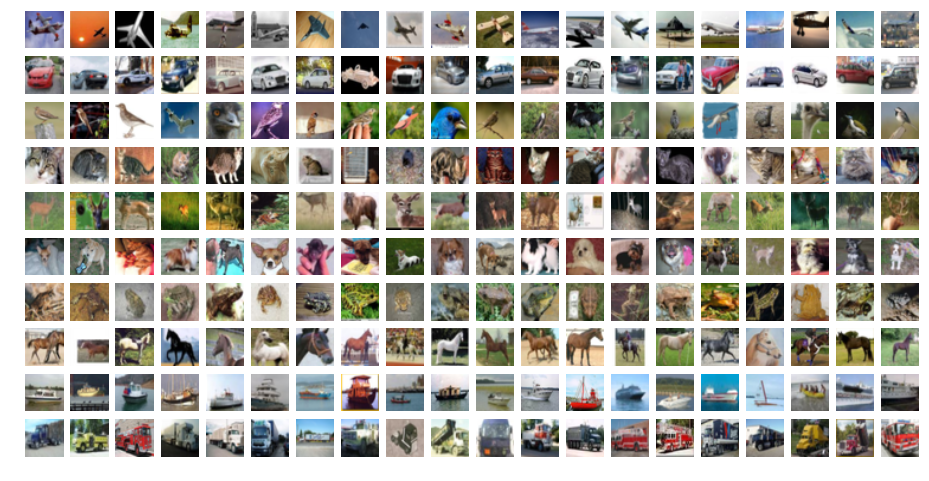

In [4]:
figsize(16, 8)
_, axls = plt.subplots(10, 20)
for x, axl in enumerate(axls):
    category_ims = train_images[train_labels == x]
    ixs = np.arange(category_ims.shape[0])
    np.random.shuffle(ixs)
    for ax, im in zip(axl, category_ims[ixs]):
        ax.imshow(im)
        ax.axis("off")
plt.show()

## Baseline Model: Convolutions with Leaky ReLU Nonlinearity

In [5]:
def LeakydModel():
    m = models.Sequential()
    m.add(layers.Conv2D(16, 5, 5, input_shape=(32, 32, 3)))
    m.add(layers.LeakyReLU(0.2))
    m.add(layers.Conv2D(16, 3, 3))
    m.add(layers.LeakyReLU(0.2))
    m.add(layers.MaxPooling2D())
    m.add(layers.Conv2D(64, 3, 3))
    m.add(layers.LeakyReLU(0.2))
    m.add(layers.MaxPooling2D())
    m.add(layers.Flatten())
    m.add(layers.Dropout(0.5))
    m.add(layers.Dense(10, activation="softmax"))
    return m

In [6]:
lm = LeakydModel()
for l in lm.layers:
    print l.name, l.input_shape, "=>", l.output_shape
lm.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"],)

convolution2d_1 (None, 32, 32, 3) => (None, 28, 28, 16)
leakyrelu_1 (None, 28, 28, 16) => (None, 28, 28, 16)
convolution2d_2 (None, 28, 28, 16) => (None, 26, 26, 16)
leakyrelu_2 (None, 26, 26, 16) => (None, 26, 26, 16)
maxpooling2d_1 (None, 26, 26, 16) => (None, 13, 13, 16)
convolution2d_3 (None, 13, 13, 16) => (None, 11, 11, 64)
leakyrelu_3 (None, 11, 11, 64) => (None, 11, 11, 64)
maxpooling2d_2 (None, 11, 11, 64) => (None, 5, 5, 64)
flatten_1 (None, 5, 5, 64) => (None, 1600)
dropout_1 (None, 1600) => (None, 1600)
dense_1 (None, 1600) => (None, 10)


In [7]:
lm_hist = lm.fit(
    train_images, train_labels_onehot,
    batch_size=128,
    nb_epoch=40,
    verbose=1,
    validation_data=(test_images, test_labels_onehot),
    shuffle=True)

Train on 50000 samples, validate on 10000 samples
Epoch 1/40
50000/50000 [==============================] - 127s - loss: 1.7555 - acc: 0.3618 - val_loss: 1.5329 - val_acc: 0.4486
Epoch 2/40
50000/50000 [==============================] - 118s - loss: 1.4788 - acc: 0.4688 - val_loss: 1.3780 - val_acc: 0.5066
Epoch 3/40
50000/50000 [==============================] - 119s - loss: 1.3750 - acc: 0.5104 - val_loss: 1.2938 - val_acc: 0.5398
Epoch 4/40
50000/50000 [==============================] - 122s - loss: 1.2969 - acc: 0.5436 - val_loss: 1.2158 - val_acc: 0.5735
Epoch 5/40
50000/50000 [==============================] - 117s - loss: 1.2306 - acc: 0.5712 - val_loss: 1.1808 - val_acc: 0.5890
Epoch 6/40
50000/50000 [==============================] - 114s - loss: 1.1767 - acc: 0.5890 - val_loss: 1.1161 - val_acc: 0.6104
Epoch 7/40
50000/50000 [==============================] - 113s - loss: 1.1356 - acc: 0.6036 - val_loss: 1.0981 - val_acc: 0.6221
Epoch 8/40
50000/50000 [=======================

## Proposed Model: Convolutions with Depthwise Spherical Nonlinearity
For each image, the activations of the channels in each layer at each pixel are normalized to have magnitude of 1.

In [8]:
class DepthwiseSphericalLayer(Layer):
    
    def __init__(self, n_spheres=None, **kwargs):
        self.n_chan = None
        self.n_spheres = n_spheres
        super(DepthwiseSphericalLayer, self).__init__(**kwargs)
        
    def _norm(self, imgs):
        return K.sqrt(K.sum(K.square(imgs), axis=3, keepdims=True))
    
    def build(self, input_shape):
        if len(input_shape) != 4:
            raise ValueError("Expected input shape of length 4; saw {}".format(
                input_shape))
        self.n_chan = input_shape[-1]
        self.chan_per_sphere = int(np.ceil(self.n_chan / float(self.n_spheres)))
    
    def call(self, x, mask=None):
        starts = np.arange(self.n_spheres) * self.chan_per_sphere
        stops = np.minimum(starts + self.chan_per_sphere, self.n_chan)
        img_slices = [x[:, :, :, start:stop] for start, stop in zip(starts, stops)]
        norms = [self._norm(sl) for sl in img_slices]
        normed_slices = [sl / n for sl, n in zip(img_slices, norms)]
        return K.concatenate(normed_slices)
    
    def get_output_shape_for(self, input_shape):
        return input_shape

In [9]:
def SphereModel(n_spheres=2):
    if not isinstance(n_spheres, list):
        n_spheres = [n_spheres] * 3
    m = models.Sequential()
    m.add(layers.Conv2D(16, 5, 5, input_shape=(32, 32, 3)))
    m.add(DepthwiseSphericalLayer(n_spheres=n_spheres[0]))
    m.add(layers.Conv2D(16, 3, 3))
    m.add(DepthwiseSphericalLayer(n_spheres=n_spheres[1]))
    m.add(layers.MaxPooling2D())
    m.add(layers.Conv2D(64, 3, 3))
    m.add(DepthwiseSphericalLayer(n_spheres=n_spheres[2]))
    m.add(layers.MaxPooling2D())
    m.add(layers.Flatten())
    m.add(layers.Dropout(0.5))
    m.add(layers.Dense(10, activation="softmax"))
    return m

In [10]:
sm = SphereModel(n_spheres=[2, 2, 8])
for l in sm.layers:
    print l.name, l.input_shape, "=>", l.output_shape
sm.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"],)

convolution2d_4 (None, 32, 32, 3) => (None, 28, 28, 16)
depthwisesphericallayer_1 (None, 28, 28, 16) => (None, 28, 28, 16)
convolution2d_5 (None, 28, 28, 16) => (None, 26, 26, 16)
depthwisesphericallayer_2 (None, 26, 26, 16) => (None, 26, 26, 16)
maxpooling2d_3 (None, 26, 26, 16) => (None, 13, 13, 16)
convolution2d_6 (None, 13, 13, 16) => (None, 11, 11, 64)
depthwisesphericallayer_3 (None, 11, 11, 64) => (None, 11, 11, 64)
maxpooling2d_4 (None, 11, 11, 64) => (None, 5, 5, 64)
flatten_2 (None, 5, 5, 64) => (None, 1600)
dropout_2 (None, 1600) => (None, 1600)
dense_2 (None, 1600) => (None, 10)


In [11]:
sm_hist = sm.fit(
    train_images, train_labels_onehot,
    batch_size=128,
    nb_epoch=40,
    verbose=1,
    validation_data=(test_images, test_labels_onehot),
    shuffle=True)

Train on 50000 samples, validate on 10000 samples
Epoch 1/40
50000/50000 [==============================] - 256s - loss: 1.6511 - acc: 0.4001 - val_loss: 1.3514 - val_acc: 0.5182
Epoch 2/40
50000/50000 [==============================] - 257s - loss: 1.3009 - acc: 0.5378 - val_loss: 1.1754 - val_acc: 0.5878
Epoch 3/40
50000/50000 [==============================] - 257s - loss: 1.1813 - acc: 0.5840 - val_loss: 1.1112 - val_acc: 0.6145
Epoch 4/40
50000/50000 [==============================] - 256s - loss: 1.1233 - acc: 0.6042 - val_loss: 1.0608 - val_acc: 0.6235
Epoch 5/40
50000/50000 [==============================] - 257s - loss: 1.0848 - acc: 0.6190 - val_loss: 1.0432 - val_acc: 0.6325
Epoch 6/40
50000/50000 [==============================] - 257s - loss: 1.0580 - acc: 0.6326 - val_loss: 1.0133 - val_acc: 0.6477
Epoch 7/40
50000/50000 [==============================] - 277s - loss: 1.0370 - acc: 0.6356 - val_loss: 0.9982 - val_acc: 0.6484
Epoch 8/40
50000/50000 [=======================

## Hybrid Model: Spherical Nonlinearity in the First Layer, Leaky ReLU Thereafter

In [12]:
def HybridModel(n_spheres=2):
    m = models.Sequential()
    m.add(layers.Conv2D(16, 5, 5, input_shape=(32, 32, 3)))
    m.add(DepthwiseSphericalLayer(n_spheres=n_spheres))
    m.add(layers.Conv2D(16, 3, 3))
    m.add(layers.LeakyReLU(0.2))
    m.add(layers.MaxPooling2D())
    m.add(layers.Conv2D(64, 3, 3))
    m.add(layers.LeakyReLU(0.2))
    m.add(layers.MaxPooling2D())
    m.add(layers.Flatten())
    m.add(layers.Dropout(0.5))
    m.add(layers.Dense(10, activation="softmax"))
    return m

In [13]:
hm = HybridModel(n_spheres=2)
for l in hm.layers:
    print l.name, l.input_shape, "=>", l.output_shape
hm.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"],)

convolution2d_7 (None, 32, 32, 3) => (None, 28, 28, 16)
depthwisesphericallayer_4 (None, 28, 28, 16) => (None, 28, 28, 16)
convolution2d_8 (None, 28, 28, 16) => (None, 26, 26, 16)
leakyrelu_4 (None, 26, 26, 16) => (None, 26, 26, 16)
maxpooling2d_5 (None, 26, 26, 16) => (None, 13, 13, 16)
convolution2d_9 (None, 13, 13, 16) => (None, 11, 11, 64)
leakyrelu_5 (None, 11, 11, 64) => (None, 11, 11, 64)
maxpooling2d_6 (None, 11, 11, 64) => (None, 5, 5, 64)
flatten_3 (None, 5, 5, 64) => (None, 1600)
dropout_3 (None, 1600) => (None, 1600)
dense_3 (None, 1600) => (None, 10)


In [14]:
hm_hist = hm.fit(
    train_images, train_labels_onehot,
    batch_size=128,
    nb_epoch=40,
    verbose=1,
    validation_data=(test_images, test_labels_onehot),
    shuffle=True)

Train on 50000 samples, validate on 10000 samples
Epoch 1/40
50000/50000 [==============================] - 174s - loss: 1.6859 - acc: 0.3779 - val_loss: 1.4330 - val_acc: 0.4762
Epoch 2/40
50000/50000 [==============================] - 174s - loss: 1.3615 - acc: 0.5111 - val_loss: 1.2996 - val_acc: 0.5484
Epoch 3/40
50000/50000 [==============================] - 175s - loss: 1.2178 - acc: 0.5692 - val_loss: 1.1245 - val_acc: 0.6149
Epoch 4/40
50000/50000 [==============================] - 173s - loss: 1.1312 - acc: 0.6036 - val_loss: 1.0606 - val_acc: 0.6354
Epoch 5/40
50000/50000 [==============================] - 173s - loss: 1.0742 - acc: 0.6251 - val_loss: 0.9998 - val_acc: 0.6595
Epoch 6/40
50000/50000 [==============================] - 173s - loss: 1.0339 - acc: 0.6395 - val_loss: 0.9918 - val_acc: 0.6556
Epoch 7/40
50000/50000 [==============================] - 173s - loss: 1.0021 - acc: 0.6524 - val_loss: 0.9379 - val_acc: 0.6789
Epoch 8/40
50000/50000 [=======================

## Residual Model: ResNet-style blocks w/ the Depthwise Spherical in place of BatchNorm

In [15]:
def DoubleChannels(x):
    return layers.merge([x, x], mode="concat", concat_axis=-1)

def SphericalResidualBlock(x, double_channels=False):
    in_sphere = DepthwiseSphericalLayer(n_spheres=2)(x)
    if double_channels:
        in_sphere = DoubleChannels(in_sphere)
    n_channels = int(in_sphere.get_shape()[-1])
    c1 = layers.Conv2D(n_channels, 3, 3, border_mode="same")(in_sphere)
    leak1 = layers.LeakyReLU(0.2)(c1)
    c2 = layers.Conv2D(n_channels, 3, 3, border_mode="same")(leak1)
    leak2 = layers.LeakyReLU(0.2)(c2)
    return layers.merge([in_sphere, leak2], mode="sum")

def SphericalResidualModel():
    inp = layers.Input(shape=(32, 32, 3))
    c1 = layers.Conv2D(16, 5, 5, border_mode="same")(inp)
    srb1 = SphericalResidualBlock(c1)
    mp1 = layers.MaxPooling2D()(srb1)
    srb2 = SphericalResidualBlock(mp1, double_channels=True)
    mp2 = layers.MaxPooling2D()(srb2)
    srb3 = SphericalResidualBlock(mp2, double_channels=True)
    mp3 = layers.MaxPooling2D()(srb3)
    flat = layers.Flatten()(mp3)
    drop = layers.Dropout(0.5)(flat)
    dense = layers.Dense(10, activation="softmax")(drop)
    m = models.Model(input=inp, output=dense)
    return m

In [16]:
srm = SphericalResidualModel()
for l in srm.layers:
    print l.name, l.input_shape, "=>", l.output_shape
srm.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"],)

input_1 (None, 32, 32, 3) => (None, 32, 32, 3)
convolution2d_10 (None, 32, 32, 3) => (None, 32, 32, 16)
depthwisesphericallayer_5 (None, 32, 32, 16) => (None, 32, 32, 16)
convolution2d_11 (None, 32, 32, 16) => (None, 32, 32, 16)
leakyrelu_6 (None, 32, 32, 16) => (None, 32, 32, 16)
convolution2d_12 (None, 32, 32, 16) => (None, 32, 32, 16)
leakyrelu_7 (None, 32, 32, 16) => (None, 32, 32, 16)
merge_1 [(None, 32, 32, 16), (None, 32, 32, 16)] => (None, 32, 32, 16)
maxpooling2d_7 (None, 32, 32, 16) => (None, 16, 16, 16)
depthwisesphericallayer_6 (None, 16, 16, 16) => (None, 16, 16, 16)
merge_2 [(None, 16, 16, 16), (None, 16, 16, 16)] => (None, 16, 16, 32)
convolution2d_13 (None, 16, 16, 32) => (None, 16, 16, 32)
leakyrelu_8 (None, 16, 16, 32) => (None, 16, 16, 32)
convolution2d_14 (None, 16, 16, 32) => (None, 16, 16, 32)
leakyrelu_9 (None, 16, 16, 32) => (None, 16, 16, 32)
merge_3 [(None, 16, 16, 32), (None, 16, 16, 32)] => (None, 16, 16, 32)
maxpooling2d_8 (None, 16, 16, 32) => (None, 8, 8,

In [17]:
srm_hist = srm.fit(
    train_images, train_labels_onehot,
    batch_size=128,
    nb_epoch=40,
    verbose=1,
    validation_data=(test_images, test_labels_onehot),
    shuffle=True)

Train on 50000 samples, validate on 10000 samples
Epoch 1/40
50000/50000 [==============================] - 446s - loss: 0.0062 - acc: 0.1000 - val_loss: 1.1921e-07 - val_acc: 0.1000
Epoch 2/40
50000/50000 [==============================] - 441s - loss: 1.1921e-07 - acc: 0.1000 - val_loss: 1.1921e-07 - val_acc: 0.1000
Epoch 3/40
50000/50000 [==============================] - 444s - loss: 1.1921e-07 - acc: 0.1000 - val_loss: 1.1921e-07 - val_acc: 0.1000
Epoch 4/40
50000/50000 [==============================] - 444s - loss: 1.1921e-07 - acc: 0.1000 - val_loss: 1.1921e-07 - val_acc: 0.1000
Epoch 5/40
50000/50000 [==============================] - 446s - loss: 1.1921e-07 - acc: 0.1000 - val_loss: 1.1921e-07 - val_acc: 0.1000
Epoch 6/40
50000/50000 [==============================] - 445s - loss: 1.1921e-07 - acc: 0.1000 - val_loss: 1.1921e-07 - val_acc: 0.1000
Epoch 7/40
50000/50000 [==============================] - 462s - loss: 1.1921e-07 - acc: 0.1000 - val_loss: 1.1921e-07 - val_acc: 0.

## Traditional Resnet

In [18]:
def ResBlock(x, double_channels=False):
    if double_channels:
        x = DoubleChannels(x)
    n_channels = int(x.get_shape()[-1])
    bn1 = layers.BatchNormalization()(x)
    r1 = layers.LeakyReLU(0.2)(bn1)
    c1 = layers.Conv2D(n_channels, 3, 3, border_mode="same")(r1)
    bn2 = layers.BatchNormalization()(c1)
    r2 = layers.LeakyReLU(0.2)(bn2)
    c2 = layers.Conv2D(n_channels, 3, 3, border_mode="same")(r2)
    return layers.merge([x, c2], mode="sum")

def TradResidualModel():
    inp = layers.Input(shape=(32, 32, 3))
    c1 = layers.Conv2D(16, 5, 5, border_mode="same")(inp)
    r1 = layers.LeakyReLU(0.2)(c1)
    rb1 = ResBlock(r1)
    mp1 = layers.MaxPooling2D()(rb1)
    rb2 = ResBlock(mp1, double_channels=True)
    mp2 = layers.MaxPooling2D()(rb2)
    rb3 = ResBlock(mp2, double_channels=True)
    mp3 = layers.MaxPooling2D()(rb3)
    flat = layers.Flatten()(mp3)
    drop = layers.Dropout(0.5)(flat)
    dense = layers.Dense(10, activation="softmax")(drop)
    m = models.Model(input=inp, output=dense)
    return m

In [19]:
trm = TradResidualModel()
for l in trm.layers:
    print l.name, l.input_shape, "=>", l.output_shape
trm.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"],)

input_2 (None, 32, 32, 3) => (None, 32, 32, 3)
convolution2d_17 (None, 32, 32, 3) => (None, 32, 32, 16)
leakyrelu_12 (None, 32, 32, 16) => (None, 32, 32, 16)
batchnormalization_1 (None, 32, 32, 16) => (None, 32, 32, 16)
leakyrelu_13 (None, 32, 32, 16) => (None, 32, 32, 16)
convolution2d_18 (None, 32, 32, 16) => (None, 32, 32, 16)
batchnormalization_2 (None, 32, 32, 16) => (None, 32, 32, 16)
leakyrelu_14 (None, 32, 32, 16) => (None, 32, 32, 16)
convolution2d_19 (None, 32, 32, 16) => (None, 32, 32, 16)
merge_6 [(None, 32, 32, 16), (None, 32, 32, 16)] => (None, 32, 32, 16)
maxpooling2d_10 (None, 32, 32, 16) => (None, 16, 16, 16)
merge_7 [(None, 16, 16, 16), (None, 16, 16, 16)] => (None, 16, 16, 32)
batchnormalization_3 (None, 16, 16, 32) => (None, 16, 16, 32)
leakyrelu_15 (None, 16, 16, 32) => (None, 16, 16, 32)
convolution2d_20 (None, 16, 16, 32) => (None, 16, 16, 32)
batchnormalization_4 (None, 16, 16, 32) => (None, 16, 16, 32)
leakyrelu_16 (None, 16, 16, 32) => (None, 16, 16, 32)
convo

In [20]:
trm_hist = trm.fit(
    train_images, train_labels_onehot,
    batch_size=128,
    nb_epoch=40,
    verbose=1,
    validation_data=(test_images, test_labels_onehot),
    shuffle=True)

Train on 50000 samples, validate on 10000 samples
Epoch 1/40
50000/50000 [==============================] - 537s - loss: 1.3923 - acc: 0.5037 - val_loss: 1.5544 - val_acc: 0.4382
Epoch 2/40
50000/50000 [==============================] - 535s - loss: 0.9968 - acc: 0.6490 - val_loss: 1.1125 - val_acc: 0.6126
Epoch 3/40
50000/50000 [==============================] - 537s - loss: 0.8762 - acc: 0.6909 - val_loss: 0.8508 - val_acc: 0.7016
Epoch 4/40
50000/50000 [==============================] - 535s - loss: 0.7969 - acc: 0.7202 - val_loss: 0.8799 - val_acc: 0.6930
Epoch 5/40
50000/50000 [==============================] - 536s - loss: 0.7514 - acc: 0.7345 - val_loss: 0.8264 - val_acc: 0.7096
Epoch 6/40
50000/50000 [==============================] - 541s - loss: 0.7036 - acc: 0.7525 - val_loss: 0.8436 - val_acc: 0.7122
Epoch 7/40
50000/50000 [==============================] - 557s - loss: 0.6666 - acc: 0.7673 - val_loss: 0.8399 - val_acc: 0.7195
Epoch 8/40
50000/50000 [=======================

## Hybrid Resnet: Depthwise Spherical Nonlinearity after 1st conv, Leaky ReLU Thereafter

In [21]:
def HybridResidualModel():
    inp = layers.Input(shape=(32, 32, 3))
    c1 = layers.Conv2D(16, 5, 5, border_mode="same")(inp)
    s1 = DepthwiseSphericalLayer(n_spheres=2)(c1)
    rb1 = ResBlock(s1)
    mp1 = layers.MaxPooling2D()(rb1)
    rb2 = ResBlock(mp1, double_channels=True)
    mp2 = layers.MaxPooling2D()(rb2)
    rb3 = ResBlock(mp2, double_channels=True)
    mp3 = layers.MaxPooling2D()(rb3)
    flat = layers.Flatten()(mp3)
    drop = layers.Dropout(0.5)(flat)
    dense = layers.Dense(10, activation="softmax")(drop)
    m = models.Model(input=inp, output=dense)
    return m

In [ ]:
hrm = HybridResidualModel()
for l in hrm.layers:
    print l.name, l.input_shape, "=>", l.output_shape
hrm.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"],)

input_3 (None, 32, 32, 3) => (None, 32, 32, 3)
convolution2d_24 (None, 32, 32, 3) => (None, 32, 32, 16)
depthwisesphericallayer_8 (None, 32, 32, 16) => (None, 32, 32, 16)
batchnormalization_7 (None, 32, 32, 16) => (None, 32, 32, 16)
leakyrelu_19 (None, 32, 32, 16) => (None, 32, 32, 16)
convolution2d_25 (None, 32, 32, 16) => (None, 32, 32, 16)
batchnormalization_8 (None, 32, 32, 16) => (None, 32, 32, 16)
leakyrelu_20 (None, 32, 32, 16) => (None, 32, 32, 16)
convolution2d_26 (None, 32, 32, 16) => (None, 32, 32, 16)
merge_11 [(None, 32, 32, 16), (None, 32, 32, 16)] => (None, 32, 32, 16)
maxpooling2d_13 (None, 32, 32, 16) => (None, 16, 16, 16)
merge_12 [(None, 16, 16, 16), (None, 16, 16, 16)] => (None, 16, 16, 32)
batchnormalization_9 (None, 16, 16, 32) => (None, 16, 16, 32)
leakyrelu_21 (None, 16, 16, 32) => (None, 16, 16, 32)
convolution2d_27 (None, 16, 16, 32) => (None, 16, 16, 32)
batchnormalization_10 (None, 16, 16, 32) => (None, 16, 16, 32)
leakyrelu_22 (None, 16, 16, 32) => (None, 1

In [ ]:
hrm_hist = hrm.fit(
    train_images, train_labels_onehot,
    batch_size=128,
    nb_epoch=40,
    verbose=1,
    validation_data=(test_images, test_labels_onehot),
    shuffle=True)

Train on 50000 samples, validate on 10000 samples
Epoch 1/40
33024/50000 [==================>...........] - ETA: 202s - loss: 1.4667 - acc: 0.4699

## ReslessNet: Same depth as the ResNet, without the residuals.

In [ ]:
def ResLessModel():
    m = models.Sequential()
    m.add(layers.Conv2D(16, 5, 5, border_mode="same", input_shape=(32, 32, 3)))
    m.add(layers.LeakyReLU(0.2))
    m.add(layers.BatchNormalization())
    m.add(layers.Conv2D(16, 3, 3, border_mode="same"))
    m.add(layers.LeakyReLU(0.2))
    m.add(layers.BatchNormalization())
    m.add(layers.Conv2D(16, 3, 3, border_mode="same"))
    m.add(layers.LeakyReLU(0.2))
    m.add(layers.BatchNormalization())
    m.add(layers.MaxPooling2D())
    m.add(layers.Conv2D(32, 3, 3, border_mode="same"))
    m.add(layers.LeakyReLU(0.2))
    m.add(layers.BatchNormalization())
    m.add(layers.Conv2D(32, 3, 3, border_mode="same"))
    m.add(layers.LeakyReLU(0.2))
    m.add(layers.BatchNormalization())
    m.add(layers.MaxPooling2D())
    m.add(layers.Conv2D(64, 3, 3, border_mode="same"))
    m.add(layers.LeakyReLU(0.2))
    m.add(layers.BatchNormalization())
    m.add(layers.Conv2D(64, 3, 3, border_mode="same"))
    m.add(layers.LeakyReLU(0.2))
    m.add(layers.MaxPooling2D())
    m.add(layers.Flatten())
    m.add(layers.Dropout(0.5))
    m.add(layers.Dense(10, activation="softmax"))
    return m

In [ ]:
rlm = ResLessModel()
for l in rlm.layers:
    print l.name, l.input_shape, "=>", l.output_shape
rlm.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"],)

In [ ]:
rlm_hist = rlm.fit(
    train_images, train_labels_onehot,
    batch_size=128,
    nb_epoch=40,
    verbose=1,
    validation_data=(test_images, test_labels_onehot),
    shuffle=True)

## Results

In [ ]:
labels = [
    "Baseline Leaky ReLU 16-16-64",
    "Pure Spherical 16-16-64",
    "Hybrid First Layer Sphere + Later Leaky ReLU 16-16-64",
    "Traditional Residual 16-16x2-32x2-64x2",
    "Spherical Residual 16-16x2-32x2-64x2",
    "Hyprid Residul First Layer Sphere + Later Leaky ReLU 16-16x2-32x2-64x2",
    "Non-Residual Leaky ReLU 16x3-32x2-64x2"]
histories = [lm_hist, sm_hist, hm_hist, trm_hist, srm_hist, hrm_hist, rlm_hist]
figsize(12, 6)

for s, l in zip([h.history["val_acc"] for h in histories], labels):
    plt.plot(np.arange(len(s)), s, label=l)
plt.legend(loc="best")
plt.title("Validation Accuracy by Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.show()

for s, l in zip([h.history["val_loss"] for h in histories], labels):
    plt.plot(np.arange(len(s)), s, label=l)
plt.legend(loc="best")
plt.title("Validation Loss by Epoch")
plt.xlabel("Epoch")
plt.ylabel("Categorical Cross-Entropy")
plt.show()